In [1]:
import numpy as np 
import pandas as pd
import math
from scipy.spatial.distance import cdist # Tính khoảng cách giữa các cặp điểm trong 2 tập hợp một cách hiệu quả
import matplotlib.pyplot as plt
%matplotlib inline

# Tạo bộ dữ liệu bằng thư viện scikit-learn
Ta dùm hàm `sklean.datasets.make_blobs` để tạo ra một bộ dữ liệu ngẫu nhiên có 3 cụm và 200 điểm dữ liệu cho mỗi cụm theo phân phối chuẩn.

In [2]:
# Khai báo hàm make_blobs từ thư viện sklearn
from sklearn.datasets import make_blobs
# Hàm make_blobs tạo bộ dữ liệu ngẫu nhiên trả về X là danh sách các mẫu và y là danh sách nhãn của các mẫu
X, y = make_blobs(n_samples=600, 
                  n_features=2, 
                  centers=3, 
                  cluster_std=1, 
                  shuffle=True, 
                  random_state=2)

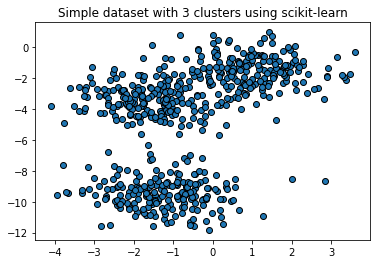

In [3]:
#Minh hoạ kết quả
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], edgecolor='k')
plt.title('Simple dataset with 3 clusters using scikit-learn')
plt.show()

# Thuật toán Hierarchical


Hàm `single_linkage` tạo nhãn cho dữ liệu dựa trên khoảng cách gần nhất giữa các cụm.

In [4]:
def single_linkage(data, dist, cutoff):
    '''
    - Thực hiện phân cụm dựa trên khoảng cách ngắn nhất giữa các cụm.
    - Các tham số:
    ----------------------
        data : np.ndarray / DataFrame
            Dữ liệu đầu vào.
        dist : np.ndarray
            Ma trận khoảng cách giữa các mẫu trong data.
        cutoff : int
            
    - Trả về:
    ----------------------
        d : dict
            Từ điển ghi lại các điểm hoặc các cụm đang được hợp nhất. Có thể dùng để tạo dendrogram.
        label : DataFrame
            Danh sách nhãn của các điểm dữ liệu trong data.
    '''
    # Khởi tạo một dataframe để chứa nhãn của các điểm dữ liệu
    df = pd.DataFrame(data=np.ones(data.shape[0])*np.inf) 
    # Khởi tạo một dictionary để chứa các điểm hoặc  các cụm đang được hợp nhất
    d = {} 
    for i in range(0,cutoff):
        ij_min = np.unravel_index(dist.argmin(), dist.shape) 
        
        if i == 0:
            df.iloc[ij_min[0]] = 0
            df.iloc[ij_min[1]] = 0
        else:
            try:
                a = int(df.iloc[ij_min[0]])
            except:
                df.iloc[ij_min[0]] = i
                a = i
            try:
                b = int(df.iloc[ij_min[1]])
            except:
                df.iloc[ij_min[1]] = i
                b = i
            df[(df[0]==a) | (df[0]==b)] = i
        d[i] = [ij_min]
        
        for j in range(0, ij_min[0]):
            if np.isfinite(dist[ij_min[0]][j]) and np.isfinite(dist[j][ij_min[1]]):
                #after two points/cluster are linked, to calculate new distance we take maximum distance for complete linkage
                dist[j][ij_min[1]] = min(dist[ij_min[0]][j], dist[j][ij_min[1]])
                
        dist[ij_min[0]] = np.inf
        label = df[0]
        
    return d, label

Hàm `complete_linkage` tạo nhãn cho dữ liệu dựa trên khoảng cách xa nhất giữa các cụm.

In [5]:
def complete_linkage(data, dist, cutoff):
    '''
    - Thực hiện phân cụm dựa trên khoảng cách xa nhất giữa các cụm.
    - Các tham số:
    ----------------------
        data : np.ndarray / DataFrame
            Dữ liệu đầu vào.
        dist : np.ndarray
            Ma trận khoảng cách giữa các mẫu trong data.
        cutoff : int
            
    - Trả về:
    ----------------------
        d_complete : dict
            Từ điển ghi lại các điểm hoặc các cụm đang được hợp nhất. Có thể dùng để tạo dendrogram.
        label : DataFrame
            Danh sách nhãn của các điểm dữ liệu trong data.
    '''
    # Khởi tạo một dataframe để chứa nhãn của các điểm dữ liệu
    df = pd.DataFrame(data=np.ones(data.shape[0])*np.inf) 
    # Khởi tạo một dictionary để chứa các điểm hoặc  các cụm đang được hợp nhất
    d_complete = {}
    for i in range(0,cutoff):
        ij_min = np.unravel_index(dist.argmin(), dist.shape)
        if i == 0:
            df.iloc[ij_min[0]] = 0
            df.iloc[ij_min[1]] = 0
        else:
            try:
                a = int(df.iloc[ij_min[0]])
            except:
                df.iloc[ij_min[0]] = i
                a = i
            try:
                b = int(df.iloc[ij_min[1]])
            except:
                df.iloc[ij_min[1]] = i
                b = i
            df[(df[0]==a) | (df[0]==b)] = i
        d_complete[i] = ij_min
        for j in range(0, ij_min[0]):
            if np.isfinite(dist[ij_min[0]][j]) and np.isfinite(dist[j][ij_min[1]]):
                #after two points/cluster are linked, to calculate new distance we take maximum distance for complete linkage
                dist[j][ij_min[1]] = max(dist[ij_min[0]][j], dist[j][ij_min[1]])
        dist[ij_min[0]] = np.inf
        label = df[0]
    return d_complete, label

Hàm `avg_linkage` tạo nhãn cho dữ liệu dựa trên trung bình khoảng cách giữa các cụm.

In [6]:
def avg_linkage(data, dist, cutoff):
    '''
    - Thực hiện phân cụm dựa trên trung bình khoảng cách giữa các cụm.
    - Các tham số:
    ----------------------
        data : np.ndarray / DataFrame
            Dữ liệu đầu vào.
        dist : np.ndarray
            Ma trận khoảng cách giữa các mẫu trong data.
        cutoff : int
            
    - Trả về:
    ----------------------
        d_average : dict
            Từ điển ghi lại các điểm hoặc các cụm đang được hợp nhất. Có thể dùng để tạo dendrogram.
        label : DataFrame
            Danh sách nhãn của các điểm dữ liệu trong data.
    '''
    # Khởi tạo một dataframe để chứa nhãn của các điểm dữ liệu
    df = pd.DataFrame(data=np.ones(data.shape[0])*np.inf) 
    # Khởi tạo một dictionary để chứa các điểm hoặc  các cụm đang được hợp nhất
    d_average = {}
    for i in range(0,cutoff):
        ij_min = np.unravel_index(dist.argmin(), dist.shape)
        if i == 0:
            df.iloc[ij_min[0]] = 0
            df.iloc[ij_min[1]] = 0
        else:
            try:
                a = int(df.iloc[ij_min[0]])
            except:
                df.iloc[ij_min[0]] = i
                a = i
            try:
                b = int(df.iloc[ij_min[1]])
            except:
                df.iloc[ij_min[1]] = i
                b = i
            df[(df[0]==a) | (df[0]==b)] = i
        d_average[i] = ij_min
        for j in range(0, ij_min[0]):
            if np.isfinite(dist[ij_min[0]][j]) and np.isfinite(dist[j][ij_min[1]]):
                dist[j][ij_min[1]] = (dist[ij_min[0]][j] + dist[j][ij_min[1]])/2.0          
        dist[ij_min[0]] = np.inf
        label = df[0]
    return d_average, label

Hàm chính của thuật toán Hierarchical.

In [7]:
def OwnHeirarchical(data, n_clusters, linkage = 'single'):
    '''
    - Thực hiện phân cụm dữ liệu bằng thuật toán Hierarchical.
    - Các tham số:
    ----------------------
        data : np.ndarray / DataFrame
            Dữ liệu đầu vào.
        n_clusters : int
            Số cụm cần tìm.
        linkage : {'single', 'complete', 'average'}, mặc định là 'complete'
            Phương thức liên kết.
    - Trả về:
    ----------------------
        cluters : dict
            Từ điển ghi lại các điểm hoặc các cụm đang được hợp nhất. Có thể dùng để tạo dendrogram.
        label : np.ndarray
            Danh sách nhãn của dữ liệu
    '''
    #This is done using dynamic programming approach
    # if 1, it is single linkage else 2 is complete linkage, 3 is average linkage
    #Step 1 - Calculate distance matrix
    distance_matrix = cdist(data, data) 
    #Step 2 - Since matrix is symmetric, we just keep lower triangle matrix
    distance_matrix = np.tril(distance_matrix) 
    #Step 3 - Replace 0 by inf, it makes it easy for us to extract minimum using min function
    distance_matrix[distance_matrix == 0] = np.inf 
    #If user provides impractical cut-off, cluster everthing into one cluster and not listen to user 
    cutoff = data.shape[0] - n_clusters
    if cutoff > distance_matrix.shape[0]: #If user provides impractical cut-off, cluster everthing into one cluster and not listen to user 
        cutoff = distance_matrix.shape[0]
    #This 1 means formula of single linkage will be used, it is explained ahead
    if linkage == 'single':
        clusters, label = single_linkage(data, distance_matrix, cutoff)
    elif linkage == 'complete':
        clusters, label = complete_linkage(data, distance_matrix, cutoff)
    else:
        clusters, label = avg_linkage(data, distance_matrix, cutoff)
    i = 0
    for clust in label.unique():
        if clust == np.inf:
            continue
        else:
            label.loc[label==clust] = clust - clust + i
            i = i + 1
    for j in range(len(label)):
        if label[j] == np.inf:
            label[j] = i
            i = i + 1
    label = label.to_numpy().astype(int)
    return clusters, label

# Áp dụng thuật toán vừa viết vào dữ liệu ban đầu

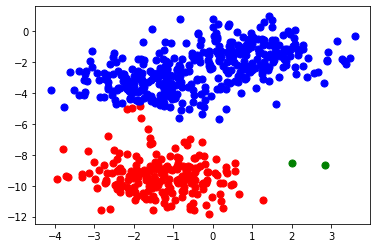

In [8]:
clusters_single, label_single = OwnHeirarchical(X, 3, 'single')
# Mô tả kết quả
plt.scatter(X[label_single==0, 0], X[label_single==0, 1], s=50, marker='o', color='red')
plt.scatter(X[label_single==1, 0], X[label_single==1, 1], s=50, marker='o', color='blue')
plt.scatter(X[label_single==2, 0], X[label_single==2, 1], s=50, marker='o', color='green')
plt.show()

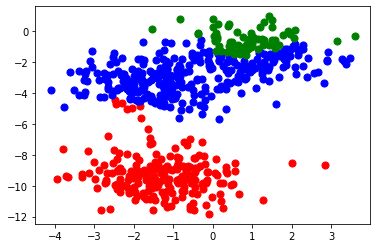

In [9]:
clusters_complete, label_complete = OwnHeirarchical(X, 3, 'complete')
# Mô tả kết quả
plt.scatter(X[label_complete==0, 0], X[label_complete==0, 1], s=50, marker='o', color='red')
plt.scatter(X[label_complete==1, 0], X[label_complete==1, 1], s=50, marker='o', color='blue')
plt.scatter(X[label_complete==2, 0], X[label_complete==2, 1], s=50, marker='o', color='green')
plt.show()

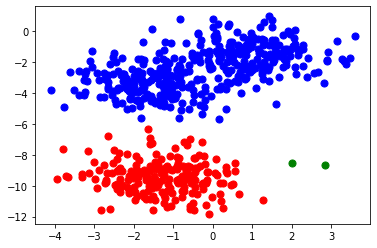

In [10]:
clusters_avg, label_avg = OwnHeirarchical(X, 3, 'average')
# Mô tả kết quả
plt.scatter(X[label_avg==0, 0], X[label_avg==0, 1], s=50, marker='o', color='red')
plt.scatter(X[label_avg==1, 0], X[label_avg==1, 1], s=50, marker='o', color='blue')
plt.scatter(X[label_avg==2, 0], X[label_avg==2, 1], s=50, marker='o', color='green')
plt.show()

# Kết quả tìm được bằng thư viện scikit-learn
Ta sử dụng hàm `AgglomerativeClustering` trong thư viện `scikit-learn` để thực thi thuật toán Hierarchical.

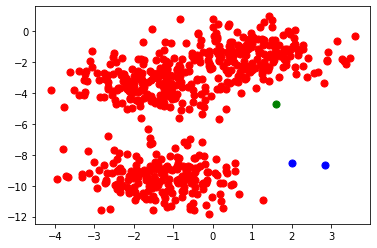

In [11]:
# Khai báo hàm AgglomerativeClustering từ thư viện scikit-learn
from sklearn.cluster import AgglomerativeClustering
# Khởi tạo thuật toán Agglomerative Clustering với 3 cụm và linkage = single
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='single')
# Áp dụng mô hình trên cho dữ liệu X
model.fit(X)
# Lấy ra danh sách nhãn của từng điểm dữ liệu trong X sau khi áp dụng mô hình
labels = model.labels_
# Mô tả kết quả
plt.scatter(X[labels==0, 0], X[labels==0, 1], s=50, marker='o', color='red')
plt.scatter(X[labels==1, 0], X[labels==1, 1], s=50, marker='o', color='blue')
plt.scatter(X[labels==2, 0], X[labels==2, 1], s=50, marker='o', color='green')
plt.show()

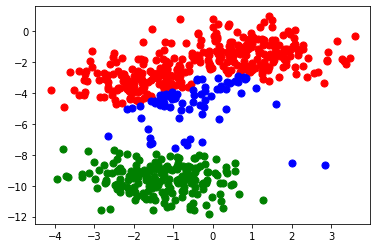

In [12]:
# Khởi tạo thuật toán Agglomerative Clustering với 3 cụm và linkage = complete
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
# Áp dụng mô hình trên cho dữ liệu X
model.fit(X)
# Lấy ra danh sách nhãn của từng điểm dữ liệu trong X sau khi áp dụng mô hình
labels = model.labels_
# Mô tả kết quả
plt.scatter(X[labels==0, 0], X[labels==0, 1], s=50, marker='o', color='red')
plt.scatter(X[labels==1, 0], X[labels==1, 1], s=50, marker='o', color='blue')
plt.scatter(X[labels==2, 0], X[labels==2, 1], s=50, marker='o', color='green')
plt.show()

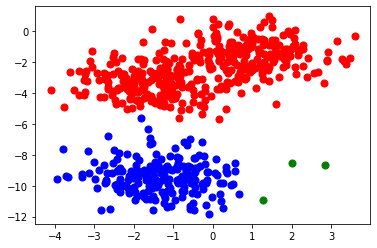

In [13]:
# Khởi tạo thuật toán Agglomerative Clustering với 3 cụm và linkage = average
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average')
# Áp dụng mô hình trên cho dữ liệu X
model.fit(X)
# Lấy ra danh sách nhãn của từng điểm dữ liệu trong X sau khi áp dụng mô hình
labels = model.labels_
# Mô tả kết quả
plt.scatter(X[labels==0, 0], X[labels==0, 1], s=50, marker='o', color='red')
plt.scatter(X[labels==1, 0], X[labels==1, 1], s=50, marker='o', color='blue')
plt.scatter(X[labels==2, 0], X[labels==2, 1], s=50, marker='o', color='green')
plt.show()

# Thực thi thuật toán Hierarchical trên bộ dữ liệu thực
Trong phần này, ta sẽ sử dụng bộ dữ liệu `iris` từ thư viện `scikit-learn`

In [14]:
from sklearn.datasets import load_iris
#Load dữ liệu
data, original_label = load_iris(return_X_y=True, as_frame=True)
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [15]:
print(">> Shape of data: ", data.shape)

>> Shape of data:  (150, 4)


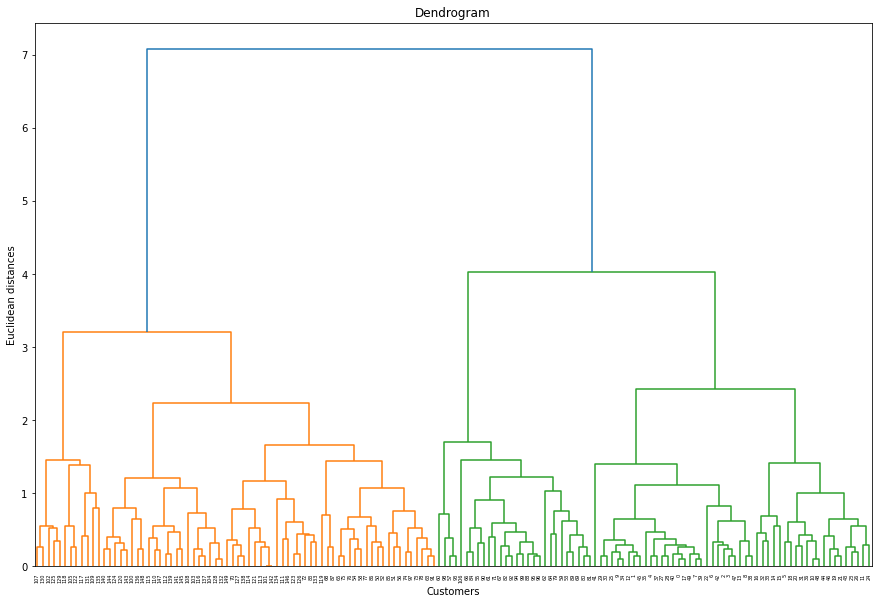

(149, 4)


In [16]:
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(15, 10))
dendrogram = sch.dendrogram(sch.linkage(data, method='complete'), leaf_rotation=90, leaf_font_size=5)
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()
print(sch.linkage(data, method='complete').shape)

## Thực thi thuật toán Hierarchical 

In [17]:
clusters_complete, label_complete = OwnHeirarchical(data, 3, 'complete')

## Thực thi thuật toán Hierarchical bằng thư viện scikit-learn

In [18]:
# Khởi tạo thuật toán Agglomerative Clustering với 3 cụm và linkage = complete
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
# Áp dụng mô hình trên cho dữ liệu X
model.fit(data)
# Lấy ra danh sách nhãn của từng điểm dữ liệu trong X sau khi áp dụng mô hình
labels = model.labels_

## So sánh kết quả

In [19]:
print(">> Predicted labels using our algorithm :")
print(label_complete)
print(">> Predicted labels found by scikit-learn :")
print(labels)

>> Predicted labels using our algorithm :
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 1 1 1 2 1 2 2 1 2 1 2 1 1 1 2 2 1 1 1 1
 1 1 1 1 1 2 2 2 1 1 1 1 1 2 1 2 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
>> Predicted labels found by scikit-learn :
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 2 0 2 0 2 0 2 2 2 2 0 2 0 2 2 0 2 0 2 0 0
 0 0 0 0 0 2 2 2 2 0 2 0 0 0 2 2 2 0 2 2 2 2 2 0 2 2 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


# PCA dữ liệu để mô phỏng bằng scatter plot

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Chuẩn hóa dữ liệu
sc = StandardScaler()

X_std = sc.fit_transform(data)
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_std)

Mô phỏng nhãn mặc định của dữ liệu

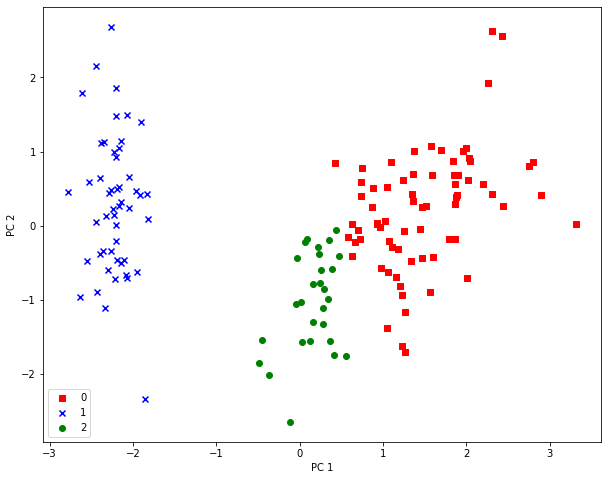

In [21]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

fig, ax = plt.subplots(figsize = (10, 8))

for l, c, m in zip(np.unique(labels), colors, markers):
    ax.scatter(X_pca[labels == l, 0], X_pca[labels == l, 1], c = c, label = l, marker = m)
ax.set(xlabel = 'PC 1', ylabel = 'PC 2')
plt.legend(loc='lower left')
plt.show()

Mô phỏng nhãn dữ đoán khi dùng hàm hierarchical.

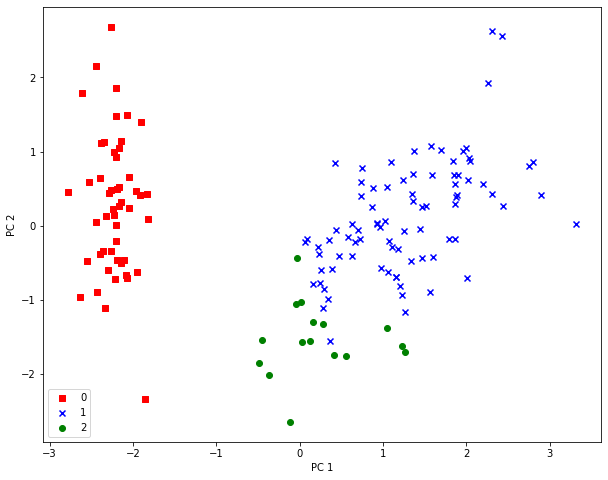

In [22]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

fig, ax = plt.subplots(figsize = (10, 8))

for l, c, m in zip(np.unique(label_complete), colors, markers):
    ax.scatter(X_pca[label_complete == l, 0], X_pca[label_complete == l, 1], c = c, label = l, marker = m)
ax.set(xlabel = 'PC 1', ylabel = 'PC 2')
plt.legend(loc='lower left')
plt.show()